# Facial Features Extraction

<h3>Conclusion:</h3>
<h4><b>Detect and Extract facial features into separate images.</b></h4>
<br>
<h4><b>Note:</b></h4>
<p>
    Some improvements are applied to the landmarks detection, for more information visit <a href="https://www.kaggle.com/zeyadkhalid/full-face-81-landmarks-detection-highly-improved" target="_blank">(this)</a> notebook
</p>

<h3>Features:</h3>
<ol>
    <li>
        <b>Forehead</b>
    </li>
     <li>
        <b>Left Eyebrow</b>
    </li>
    <li>
        <b>Right Eyebrow</b>
    </li>
    <li>
        <b>Both Eyebrows</b>
    </li>
    <li>
        <b>Left Eye</b>
    </li>
    <li>
        <b>Right Eye</b>
    </li>
    <li>
        <b>Both Eyes</b>
    </li>
    <li>
        <b>Left Eye and Eyebrow</b>
    </li>
    <li>
        <b>Right Eye and Eyebrow</b>
    </li>
    <li>
        <b>Both Eyes and Eyebrows</b>
    </li>
    <li>
        <b>Nose</b>
    </li>
    <li>
        <b>Mouth</b>
    </li>
    <li>
        <b>Main Features (Eyebrows, Eyes, Nose, Mouth)</b>
    </li>
    <li>
        <b>Clear Eye</b>: 'Clear' represents either left or right side, it means the closer side of the face to the view, it's useful when the face is NOT looking straight
    </li>
    <li>
        <b>Clear Eyebrow</b>
    </li>
    <li>
        <b>Clear Eye and Eyebrow</b>
    </li>
</ol>
<h3><b>Inspirational Ideas</b></h3>
<ul>
    <li>Emotion Recognition from facial features</li>
    <li>Face Identification / Authentication</li>
    <li>Detect personality traits from facial features</li>
    <li>Gender Classification</li>
    <li>Down Syndrome Detection</li>
</ul>

In [1]:
! pip install imutils

import os
import math
import cv2
import dlib
import numpy as np
import pandas as pd
from imutils import face_utils
import matplotlib.pyplot as plt

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=7b040ab4207a852965fbd0882a43fde0d423f567f1017cf09c75a0055b9c90f1
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [2]:
# Define required maths functions

def slope(point1, point2, absolute=False):
    x1,y1 = point1
    x2,y2 = point2
    deltaX = x2-x1
    deltaY = y2-y1
    if deltaX == 0:
        return "inf"
    slope = deltaY / deltaX
    if absolute:
        slope = abs(slope)
    return round(slope,3)

In [3]:
# Define helper functions

def load_images_from_folder(folder):
    images = []
    filenames = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
            filenames.append(filename)
    return images, filenames

In [4]:
# Computer Vision functions

predictor68 = dlib.shape_predictor('../input/shape-predictor-68-face-landmarks/shape_predictor_68_face_landmarks.dat')
predictor81 = dlib.shape_predictor('../input/shape-predictor81/shape_predictor_81_face_landmarks.dat')

# Function to determine the color range allowed to move landmarks points through image
def getAllowedColorRange(avgSkinColor):
    # Dark skin
    if (avgSkinColor < 100):
        colorRange = (avgSkinColor-35, avgSkinColor+50)
    # Somehow dark skin
    elif(avgSkinColor <= 130): 
        colorRange = (avgSkinColor-30, avgSkinColor+30)
    # Normal skin color (tends to dark)
    elif(avgSkinColor <= 160):
        colorRange = (avgSkinColor-40, avgSkinColor+40) 
    # Normal skin color 
    elif(avgSkinColor < 180):
        colorRange = (avgSkinColor-50, avgSkinColor+50)
    # Normal skin color (tends to white)
    elif(avgSkinColor < 210):
        colorRange = (avgSkinColor-50, avgSkinColor+30) 
    # white skin color
    elif (avgSkinColor < 230):
        colorRange = (avgSkinColor-40, avgSkinColor+20)
    # Abnormal white skin color
    else:
        colorRange = (avgSkinColor-30, avgSkinColor+15)
    return colorRange

# Function to move landmarks points, based on skincolor
def moveUp(grayscale_image, point, avgSkinColor, foreheadHeight):
    # Get color range & current color where the point is located in image
    steps = 5
    portionOfOriginalPointY = 0.275
    originalPoint = np.copy(point)
    colorRange = getAllowedColorRange(avgSkinColor)
    currentPixelColor = grayscale_image.item(point[1],point[0])
    
    # move the landmark point up until a strong change of color happen (outside color range)
    while currentPixelColor > colorRange[0] and currentPixelColor < colorRange[1]:
        
        # If point is going out of image boundary
        if point[1] < 0:
            # Get back to original point location, with a little bit higher
            point[1] = originalPoint[1] - (originalPoint[1] * portionOfOriginalPointY)
            break
            
        # move up (N steps) pixels & get the color
        point[1] = point[1] - steps
        
        currentPixelColor = grayscale_image.item(point[1],point[0])
        
    # if the pixel is moved too high than expected (3/4 forehead height): keep close to original
    if abs( originalPoint[1] - point[1] ) > ( foreheadHeight * 0.75 ):
        point[1] = originalPoint[1] - (originalPoint[1] * portionOfOriginalPointY)
    return point

# Function to detect if the forehead is clear or covered with hair (it corrupts the enhancement of landmarks points)
def clearForehead(forehead, avgSkinColor):
    clarityThreshold = 85
    colorRange = getAllowedColorRange(avgSkinColor)
    
    # Check if most of the forehead is the same as skin color
    regionOK = np.logical_and(forehead > colorRange[0] , forehead < colorRange[1])
    try:
        percentage = (np.count_nonzero(regionOK) / forehead.size) * 100
    except:
        return False
    isClear = True if percentage >= clarityThreshold else False
    return isClear


# Function to perform facial landmark detection on the whole face
def facial_landmarks(image, eyeOnlyMode=False, allowEnhancement=False):
    # ARGUMENTS:
    # - eyeOnlyMode: detect & return eye landmarks, used to align face
    # - allowEnhancement: allow improvement (landmarks repositioning)
    
    # Return:
    # - NumPy array of coordinates of landmarks
    
    # Use dlib 68 & 81 to predict landmarks points coordinates
    detector = dlib.get_frontal_face_detector()
    global predictor68
    global predictor81
    
    # Grayscale image
    try:
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    except:
        grayscale_image = image
    
    # array of rectangles surrounding faces detected
    rectangles = detector(grayscale_image, 1)

    # If at least one face is detected   
    if len(rectangles) > 0:
        # Get 68 landmark points
        faceLandmarks = predictor68(grayscale_image, rectangles[0])
        faceLandmarks = face_utils.shape_to_np(faceLandmarks)
        
        if eyeOnlyMode:
            # Return eye points to perform a calculated rotation
            return np.array([faceLandmarks[39], faceLandmarks[42]])
        
        # Get 81 landmark points
        foreheadLandmarks = predictor81(grayscale_image, rectangles[0])
        foreheadLandmarks = face_utils.shape_to_np(foreheadLandmarks)
        
        # Get 68 point from -68- predictor (higher accuracy) + forehead from -81- predictor
        fullFacePoints = np.concatenate((faceLandmarks, foreheadLandmarks[68:]))
        
        # Get forehead region & height to perform simple improvement
        x,y,x2,y2 = (fullFacePoints[69,0]-10, fullFacePoints[68,1], fullFacePoints[80,0]+10, fullFacePoints[23, 1])
        foreheadRegion = grayscale_image[y:y2,x:x2]
        foreheadHeight = foreheadRegion.shape[0]
        
        if allowEnhancement:
            # Perform progressive quality improvement
            # Get nose region to get average skin color
            x,y,x2,y2 = (fullFacePoints[28,0]-5, fullFacePoints[28,1], fullFacePoints[28,0]+5, fullFacePoints[30,1])
            noseRegion = grayscale_image[y:y2, x:x2]
            avgSkinColor = np.average(noseRegion[:,:])
            
            # Check if forehead is clear -> perform heuristic based enhancement
            forehead_is_clear = clearForehead(foreheadRegion, avgSkinColor)
            originalPoints = fullFacePoints[[69,70,71,73,80]]
            
            if forehead_is_clear:
                avgSkinColor = np.average(foreheadRegion)
                
                # Modify some points for more accuracy
                # Point[68] will be center between lower-lip & chin
                distance = int((fullFacePoints[8,1]-fullFacePoints[57,1]) / 2)
                fullFacePoints[68] = np.array([fullFacePoints[8,0], fullFacePoints[8,1]-distance])
                
                # Enhance points locations
                enhancedPoints = np.array([moveUp(grayscale_image, orgPoint, avgSkinColor, foreheadHeight) for orgPoint in originalPoints])

                # Assign original points to enhanced points (some maybe the same)
                fullFacePoints[[69,70,71,73,80]] = enhancedPoints  
                
                # Adjust points to fix any corruptions
                fullFacePoints[[69,70,71,73,80]] = adjustPoints(enhancedPoints, fullFacePoints[76], fullFacePoints[79])

                #Prepare point[72] for center of forehead
                distance = (fullFacePoints[22,0] - fullFacePoints[21,0]) / 2
                distanceY = (fullFacePoints[21,1] - fullFacePoints[71,1]) / 2
                fullFacePoints[72] = np.array([fullFacePoints[21,0] + distance, fullFacePoints[21,1]-distanceY])
                
                # Point[74] sometimes have a fixed corruption, this line helps :)
                fullFacePoints[74,0] -= foreheadHeight * 0.1 # Arbitery heurestic
                
            else:
                # If forehead isn't clear -> fix points with very simple heuristics
                fullFacePoints[70,1] -= foreheadHeight * 0.2
                fullFacePoints[71,1] -= foreheadHeight * 0.3
                fullFacePoints[80,1] -= foreheadHeight * 0.2
    
        else:
            # If Enhancement is False -> do the simple enhancement, better quality + low performance :)
            fullFacePoints[70,1] -= foreheadHeight * 0.2
            fullFacePoints[71,1] -= foreheadHeight * 0.3
            fullFacePoints[80,1] -= foreheadHeight * 0.2
            pass
        
        return fullFacePoints
    # No faces found
    else:
        return None

# Function to adjust landmarks points of the forehead 
# and fix corruptions of improvement (such as the bald man case)
def adjustPoints(points, leftSidePoint, rightSidePoint):    
    # Use shape_predictor_81 as a reference for points indexes to fix:
    # points = [69,70,71,73,80]
    # LeftSidePoint = 76  |  rightSidePoint = 79
    
    slopes = []
    slopeThreshold = 0.4 # slope > 0.4 = corruption -> fix
    totalSlopeThreshold = 1 # sum of slopes > 1 = corruption -> fix
    leftPoint = points[0]
    rightPoint = points[3]
    criticalLeftPoint = points[1]
    criticalRightPoint = points[4]
    
    # if any point is higher than a (accurate located point) -> fix
    if leftPoint[1] < criticalLeftPoint[1] :
        points[0,1] = np.average([criticalLeftPoint[1], leftSidePoint[1]])
    if rightPoint[1] < criticalRightPoint[1]:
        points[3,1] = np.average([criticalRightPoint[1], rightSidePoint[1]])
    
    # Collect some slopes of the usually corrupted points
    slopes.append(slope(points[1], points[2], True))
    slopes.append(slope(points[2], points[4], True))
    
    # Calculate slope differences & sum
    difference = abs(np.diff(slopes))
    _sum = np.sum(slopes)
    
    # If calculation results (either) too high = corruption -> fix
    if difference > slopeThreshold:
        issueIndex = np.argmax(slopes)
        if issueIndex == 0:
            points[1,1] = max(points[4,1], points[2,1])
        else:
            points[4,1] = max(points[1,1], points[2,1])
            
    if _sum > totalSlopeThreshold:
        points[1,1] = np.average(points[[4,2], 1])
        points[4,1] = np.average(points[[1,2], 1])
        points[2,1] = np.average(points[[4,1], 1])  
        
    return points

# Function to extract the whole face
def cropFullFace(image, points, padding = True, xProportion = 0.025, yProportion = 0.025):    
    imageShape = image.shape
    # Get borders of the 4 directions
    top = points[:,1].min()
    bottom = points[:,1].max()
    left = points[:,0].min()
    right = points[:,0].max()
    
    if padding:
        # X-factor is a an additional proportion of the image on X-axis, considered in the output 
        # Y-factor is the same for Y-axis 
        xFactor = int((xProportion) * imageShape[1])
        yFactor = int((yProportion) * imageShape[0])
        x,y,x2,y2 = (max(left-xFactor, 0), max(top-yFactor, 0) ,min(right+yFactor, imageShape[0]), min(bottom+yFactor, imageShape[0]) )
    
    else:
        x,y,x2,y2 = (left,top ,right, bottom )

    cropped = image[y:y2, x:x2]
    return cropped

# Function to rotate image to align the face
def align_face(image, eyePoints):
    # Get left eye & right eye coordinates
    leftEyeX,leftEyeY = eyePoints[0]
    rightEyeX, rightEyeY = eyePoints[1]

    # Calculate angle of rotation & origin point
    angle = math.atan( (leftEyeY - rightEyeY) / (leftEyeX - rightEyeX) ) * (180/math.pi)
    origin_point = tuple(np.array(image.shape[1::-1]) / 2)

    # Rotate using rotation matrix
    rot_mat = cv2.getRotationMatrix2D(origin_point, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result
    

# Function to collect landmarks points, grouped, as polygons
def collectFaceComponents(facial_points):
    faceShape = np.concatenate((facial_points[0:17],facial_points[[78,74,79,73,80,71,70,69,76,75,77,0]])) 
    leftEye = np.concatenate((facial_points[36:42],np.array([facial_points[36]])))
    rightEye = np.concatenate((facial_points[42:47],np.array([facial_points[42]])))
    leftIBrow = facial_points[17:22]
    rightIBrow = facial_points[22:27]
    noseLine = facial_points[27:31]
    noseArc = facial_points[31:36]
    upperLip = facial_points[[49,50,51,52,53,61,62,63]]
    lowerLip = facial_points[[55,56,57,58,59,65,66,67]]
    faceComponents = {
            "face_shape":faceShape,
            "left_eye":leftEye,
            "right_eye":rightEye,
            "left_i_brow":leftIBrow,
            "right_i_brow":rightIBrow,
            "nose_line":noseLine,
            "nose_arc":noseArc,
            "upper_lip":upperLip,
            "lower_lip":lowerLip
            }
    return faceComponents




In [5]:
# Facial Features Extraction
def extract_features(image, landmarks_points, options):
   # Input:
   #    + Image to process
   #    + landmarks coordinates
   #    + options: array of strings, features to be extracted
   
   # Output:
   #    + dictionary => {feature_name : image, ...}
   
   
    # Get & Initialize face components
    faceComponents = collectFaceComponents(landmarks_points)
    face_shape = faceComponents["face_shape"]
    leftEye, rightEye = faceComponents["left_eye"], faceComponents["right_eye"]
    left_ibrow, right_ibrow = faceComponents["left_i_brow"], faceComponents["right_i_brow"]
    nose_line, nose_arc = faceComponents["nose_line"], faceComponents["nose_arc"]
    upper_lip = faceComponents["upper_lip"]
    
    if 'all' in options:
        options.extend([
            'forehead', 'left_eyebrow', 'right_eyebrow',
            'left_eye', 'right_eye', 
            'left_eye_eyebrow', 'right_eye_eyebrow',
            'nose', 'mouth', 'eye_nose_mouth_eyebrow',
            'both_eyebrow', 'both_eye', 'both_eye_eyebrow', 
            'clear_eyebrow', 'clear_eye', 'clear_eye_eyebrow',
        ])
    
    # Initialize response
    features = {}
    
    # Detect the clear face side (Better capture for eye+brows))
    # distance between nose bottom-point & eyes angle-point 
    lefteyeside = leftEye[3]
    righteyeside = rightEye[0]
    noseTip = nose_line[nose_line.shape[0]-1]
    if righteyeside[0] - noseTip[0] < 0: 
        # (in your perspective), person is looking to right direction -> so Left eye is clear
        clear_eye = leftEye
        clear_ibrow = left_ibrow
        clearer_left_side = True
    elif noseTip[0] - lefteyeside[0] < 0:
        # Person is looking to left direction -> so right eye is clear
        clear_eye = rightEye
        clear_ibrow = right_ibrow
        clearer_left_side = False
    else:
        # Decide which side is clearer (person is slightly looking to right or left)
        nose_eye_diff = abs(noseTip[0]-lefteyeside[0]) - abs(noseTip[0]-righteyeside[0])
        ibrow_position = "right" if nose_eye_diff <= 1 else "left"
        clear_eye = faceComponents[ibrow_position+"_eye"]
        clear_ibrow = faceComponents[ibrow_position+"_i_brow"]
        clearer_left_side = True if ibrow_position == 'left' else False
        
    ##### Forehead #####
    if 'forehead' in options:
        x, y, x2, y2 = np.min(face_shape[:, 0]), np.min(face_shape[:, 1]), np.max(face_shape[:, 0]), np.min(clear_ibrow[:, 1])
        forehead_img = image[y:y2, x:x2] # Best resolution (224, 64)
        features['forehead'] = forehead_img
        
    
    ##### Left eyebrow #####
    if 'left_eyebrow' in options:
        # x = between left eyebrow and left side faceshape landmark [index 0 of 81]
        # x2 = nose top landmark (between eyebrows)
        # y = top eyebrow landmark,   y2 = bottom eyebrow landmark
        x = int((left_ibrow[0, 0] + face_shape[0, 0]) / 2)
        x2 =  nose_line[0, 0]
        y, y2 = np.min(left_ibrow[:, 1]), np.max(left_ibrow[:, 1])
        left_ibrow_img = image[y:y2, x:x2]
        features['left_eyebrow'] = left_ibrow_img
    
    ##### Right eyebrow #####
    if 'right_eyebrow' in options:
        # x =  nose top landmark (between eyebrows)
        # x2 = between right eyebrow and right side faceshape landmark [index 16 of 81]
        # y = top eyebrow landmark,   y2 = bottom eyebrow landmark
        # y2 = eyebrow bottom landmark
        x = nose_line[0,0]
        x2 = int((right_ibrow[4, 0] + face_shape[16, 0]) / 2)
        y, y2 = np.min(right_ibrow[:, 1]), np.max(right_ibrow[:, 1])  
        right_ibrow_img = image[y:y2, x:x2]
        features['right_eyebrow'] = right_ibrow_img
    
    
    ##### Left eye #####
    if 'left_eye' in options:
        # x = between left eye and left side faceshape landmark [index 0 of 81]
        # x2 = top landmark of nose (between eyes)
        # y = between eye top landmark & eyebrow top landmark
        # y2 = second top nose landmark
        x = int((leftEye[0, 0] + face_shape[0, 0]) / 2)
        x2 = nose_line[0, 0]
        y = int((np.min(left_ibrow[:, 1]) + np.min(leftEye[:, 1])) / 2)
        y2 = nose_line[1, 1]
        leftEye_img = image[y:y2, x:x2]
        features['left_eye'] = leftEye_img
    
    ##### Right eye #####
    if 'right_eye' in options:
        # x = top landmark of nose (between eyes)
        # x2 = between right eye and right side faceshape landmark [index 16 of 81]
        # y = between eye top landmark & eyebrow top landmark
        # y2 = second top nose landmark
        x = nose_line[0, 0]
        x2 = int((rightEye[4, 0] + face_shape[16, 0]) / 2)
        y = int((np.min(right_ibrow[:, 1]) + np.min(rightEye[:, 1])) / 2)
        y2 = nose_line[1, 1]
        rightEye_img = image[y:y2, x:x2]
        features['right_eye'] = rightEye_img
    
    ##### Both eyebrows #####
    if 'both_eyebrow' in options:
        # x = between left eyebrow and left side faceshape landmark [index 0 of 81]
        # x2 = between right eyebrow and right side faceshape landmark [index 16 of 81]
        # y = top landmark of left/right eyebrow (maximum top is selected)
        # y2 = bottom landmark of left/right eyebrow (maximum bottom is selected)
        x = int((left_ibrow[0, 0] + face_shape[0, 0]) / 2)
        x2 = int((right_ibrow[4, 0] + face_shape[16, 0]) / 2)
        y = min(np.min(left_ibrow[:, 1]), np.min(right_ibrow[:, 1]))
        y2 = max(np.max(left_ibrow[:, 1]), np.max(right_ibrow[:, 1]))
        both_eyebrows_img = image[y:y2, x:x2]
        features['both_eyebrow'] = both_eyebrows_img
    
    ##### Both eyes #####
    if 'both_eye' in options:
        # x = between left eye and left side faceshape landmark [index 0 of 81]
        # x2 = between right eye and right side faceshape landmark [index 16 of 81]
        # y = between clear eyebrow & clear eye
        # y2 = second top nose landmark
        x = int((leftEye[0, 0] + face_shape[0, 0]) / 2)
        x2 = int((rightEye[4, 0] + face_shape[16, 0]) / 2)
        y = int((np.min(clear_ibrow[:, 1]) + np.min(clear_eye[:, 1])) / 2)
        y2 = nose_line[1, 1]
        both_eyes_img = image[y:y2, x:x2]
        features['both_eye'] = both_eyes_img
    
    ##### Eye and Eyebrow LEFT #####
    if 'left_eye_eyebrow' in options:
        # x = between left eyebrow and left side faceshape landmark [index 0 of 81]
        # x2 = nose top landmark (between eyebrows)
        # y = top left eyebrow landmark
        # y2 = second top nose landmark
        x = int((left_ibrow[0, 0] + face_shape[0, 0]) / 2)
        x2 =  nose_line[0, 0]
        y = np.min(left_ibrow[:, 1])
        y2 = nose_line[1, 1]
        eye_eyebrow_left =  image[y:y2, x:x2]
        features['left_eye_eyebrow'] = eye_eyebrow_left
    
    ##### Eye and Eyebrow RIGHT #####
    if 'right_eye_eyebrow' in options:
        # x = top landmark of nose (between eyes)
        # x2 = between right eyebrow and right side faceshape landmark [index 16 of 81]
        # y = top right eyebrow landmark
        # y2 = second top nose landmark
        x = nose_line[0, 0]
        x2 = int((right_ibrow[4, 0] + face_shape[16, 0]) / 2)
        y = np.min(right_ibrow[:, 1])
        y2 = nose_line[1, 1]
        eye_eyebrow_right = image[y:y2, x:x2]
        features['right_eye_eyebrow'] = eye_eyebrow_right
    
    ##### Eye and Eyebrow LEFT & RIGHT #####
    if 'both_eye_eyebrow' in options:
        # x = between left eyebrow and left side faceshape landmark [index 0 of 81]
        # x2 = between right eyebrow and right side faceshape landmark [index 16 of 81]
        # y = top eyebrow landmark
        # y2 = second top nose landmark
        x = int((left_ibrow[0, 0] + face_shape[0, 0]) / 2)
        x2 = int((right_ibrow[4, 0] + face_shape[16, 0]) / 2)
        y = min(np.min(left_ibrow[:, 1]), np.min(right_ibrow[:, 1]))
        y2 = nose_line[1, 1]
        eye_eyebrow_all = image[y:y2, x:x2]
        features['both_eye_eyebrow'] = eye_eyebrow_all
    
    
    ##### Clear Eyebrow #####
    #'Clear' represents either left or right side, 
    # it means the closer side of the face to the view, 
    # it's useful when the face is NOT looking straight
    if 'clear_eyebrow' in options:
        # x =  left face side OR nose top landmark (between eyebrows)
        # x2 = between clearer eyebrow and clearer side faceshape landmark [index 16 of 81]
        # y = top eyebrow landmark
        # y2 = eyebrow bottom landmark
        x = int((left_ibrow[0, 0] + face_shape[0, 0]) / 2) if clearer_left_side else nose_line[0,0]
        x2 = nose_line[0,0] if clearer_left_side else int((right_ibrow[4, 0] + face_shape[16, 0]) / 2)
        y, y2 = np.min(clear_ibrow[:, 1]), np.max(clear_ibrow[:, 1])  
        clear_ibrow_img = image[y:y2, x:x2]
        features['clear_eyebrow'] = clear_ibrow_img
    
    
    ##### Clear Eye #####
    #'Clear' represents either left or right side, 
    # it means the closer side of the face to the view, 
    # it's useful when the face is NOT looking straight
    if 'clear_eye' in options:
        # x = leftEye.x OR rightEye.x
        # x2 = leftEye.x2 OR rightEye.x2
        # y = between clear eyebrow and clear eye
        # y2 = second top nose landmark
        x = int((leftEye[0, 0] + face_shape[0, 0]) / 2) if clearer_left_side else nose_line[0, 0]
        x2 = nose_line[0, 0] if clearer_left_side else int((rightEye[4, 0] + face_shape[16, 0]) / 2)
        y = int((np.min(clear_ibrow[:, 1]) + np.min(clear_eye[:, 1])) / 2)
        y2 = nose_line[1,1]
        clear_eye_img = image[y:y2, x:x2]
        features['clear_eye'] = clear_eye_img
        
    
    ##### Clear Eye and Eyebrow #####
    #'Clear' represents either left or right side, 
    # it means the closer side of the face to the view, 
    # it's useful when the face is NOT looking straight
    if 'clear_eye_eyebrow' in options:
        # x =  left face side OR nose top landmark (between eyebrows)
        # x2 = between clearer eyebrow and clearer side faceshape landmark [index 16 of 81]
        # y = top eyebrow landmark
        # y2 = second top nose landmark
        x = int((left_ibrow[0, 0] + face_shape[0, 0]) / 2) if clearer_left_side else nose_line[0,0]
        x2 = nose_line[0,0] if clearer_left_side else int((right_ibrow[4, 0] + face_shape[16, 0]) / 2)
        y = np.min(clear_ibrow[:, 1])
        y2 = nose_line[1,1]
        clear_eye_eyebrow = image[y:y2, x:x2]
        features['clear_eye_eyebrow'] = clear_eye_eyebrow
        
    
    ##### Nose #####
    if 'nose' in options:
        # x = the most right landmark of left eye || nose bottom landmark if it's more left
        # x2 = the most left landmark of right eye|| nose bottom landmark if it's more right
        # y = average point on Y-axis of eyebrow
        # y2 = upper lip top landmark
        x = min(leftEye[3,0], nose_arc[0, 0])
        x2 = max(rightEye[0,0], nose_arc[4, 0])
        y = int(np.average(clear_ibrow[:, 1]))
        y2 = upper_lip[2, 1]
        nose = image[y:y2, x:x2]
        features['nose'] = nose
        

    ##### Mouth #####
    if 'mouth' in options:
        # x = left cheek [index 5 of 81]
        # x2 = right cheek [index 11 of 81]
        # y = nose bottom landmark
        # y2 = point between chin bottom landmark and lower lip [index 68 of 81]
        x = face_shape[5,0]
        x2 = face_shape[11,0]
        y = nose_arc[2, 1]
        y2 = landmarks_points[8,1] - int((landmarks_points[8,1]-landmarks_points[57,1]) / 2)
        mouth = image[y:y2, x:x2]
        features['mouth'] = mouth
    
    ##### Main Features: Eyebrow Eye Nose Mouth ##### 
    if 'eye_nose_mouth_eyebrow' in options:
        # x = between left eyebrow and left side faceshape landmark [index 0 of 81]
        # x2 = between right eyebrow and right side faceshape landmark [index 16 of 81]
        # y = top eyebrow landmark
        # y2 =point between chin bottom landmark and lower lip [index 68 of 81]
        x = int((left_ibrow[0, 0] + face_shape[0, 0]) / 2)
        x2 = int((right_ibrow[4, 0] + face_shape[16, 0]) / 2)
        y = min(np.min(left_ibrow[:, 1]), np.min(right_ibrow[:, 1]))
        y2 = landmarks_points[8,1] - int((landmarks_points[8,1]-landmarks_points[57,1]) / 2)
        general_features = image[y:y2, x:x2]
        features['eye_nose_mouth_eyebrow'] = general_features
    
    return features


In [6]:
# Drawing Functions

# Function to draw points on facial features
def drawPoints(image, points, pointColor=(255,255,255), lineColor=(255,255,255), pointThickness=None, lineThickness=1):
    if pointThickness is None:
        pointThickness = round((7/1200) * image.shape[1])
    imgcopy = image.copy()
    for i in points:
        x,y = i
        imgcopy = cv2.circle(imgcopy, (x,y), radius=0, color=pointColor, thickness=pointThickness)
    return imgcopy

def plot_features(features):
    figsize = (6,6)
    plt.figure(figsize=figsize)
    plt.title("Forehead")
    plt.imshow(features['forehead'])
    plt.axis("off")
    plt.show()
    
    
    f, ax = plt.subplots(1,2, figsize=figsize)
    ax[0].imshow(features['left_eyebrow'])
    ax[0].set_title("Left Eyebrow")
    ax[0].set_axis_off()
    
    ax[1].imshow(features['right_eyebrow'])
    ax[1].set_title("Right Eyebrow")
    ax[1].set_axis_off()
    
    
    plt.figure(figsize=figsize)
    plt.imshow(features['both_eyebrow'])
    plt.title("Both Eyebrows")
    plt.axis("off")
    plt.show()
    
    
    f, ax = plt.subplots(1,2, figsize=figsize)
    ax[0].imshow(features['left_eye'])
    ax[0].set_title("Left Eye")
    ax[0].set_axis_off()
    
    ax[1].imshow(features['right_eye'])
    ax[1].set_title("Right Eye")
    ax[1].set_axis_off()
    
    
    plt.figure(figsize=figsize)
    plt.imshow(features['both_eye'])
    plt.title("Both Eyes")
    plt.axis("off")
    plt.show()
    
    
    f, ax = plt.subplots(1,2, figsize=figsize)
    ax[0].imshow(features['left_eye_eyebrow'])
    ax[0].set_title("Left Eye & Eyebrow")
    ax[0].set_axis_off()
    
    ax[1].imshow(features['right_eye_eyebrow'])
    ax[1].set_title("Right Eye & Eyebrow")
    ax[1].set_axis_off()
    
    
    plt.figure(figsize=figsize)
    plt.imshow(features['both_eye_eyebrow'])
    plt.title("Both Eyes & Eyebrows")
    plt.axis("off")
    plt.show()
    
    plt.figure(figsize=(4,4))
    plt.imshow(features['nose'])
    plt.title("Nose")
    plt.axis("off")
    plt.show()
    
    
    plt.figure(figsize=(4,4))
    plt.imshow(features['mouth'])
    plt.title("Mouth")
    plt.axis("off")
    plt.show()
    
    
    plt.figure(figsize=figsize)
    plt.imshow(features['eye_nose_mouth_eyebrow'])
    plt.title("Main Features")
    plt.axis("off")
    plt.show()

In [7]:
def main():
    # Capture all images in current folder & their names
    images, filesnames = load_images_from_folder('../input/face-sample')
    
    # Detect & Visualize a sample
    for originalImage in images:
        
        # Convert BGR to RGB
        originalImage = cv2.cvtColor(originalImage,cv2.COLOR_BGR2RGB)
        
        # Show Original Image
        plt.figure(figsize=(6,6))
        plt.imshow(originalImage)
        plt.axis("off")
        plt.show()
        
        # Detect eyes landmarks (used for face alignment)
        eyes_landmarks = facial_landmarks(originalImage, eyeOnlyMode=True)
        
        if eyes_landmarks is not None:
            
            # Align face
            image = align_face(originalImage, eyes_landmarks)
            
            # Detect landmarks
            improved_landmarks = facial_landmarks(image, allowEnhancement=True)

            
            # Select features to extract
            options = ['all']
            
            # Available options:
            
#             'forehead', 'left_eyebrow', 'right_eyebrow',
#             'left_eye', 'right_eye', 
#             'left_eye_eyebrow', 'right_eye_eyebrow',
#             'nose', 'mouth', 'eye_nose_mouth_eyebrow',
#             'both_eyebrow', 'both_eye', 'both_eye_eyebrow', 
#             'clear_eyebrow', 'clear_eye', 'clear_eye_eyebrow',
    
            # Extract features
            features = extract_features(originalImage, improved_landmarks, options)
            
            # Plot 13 features out of 16 (ignoring last 3)
            plot_features(features)


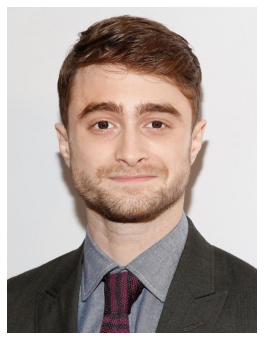

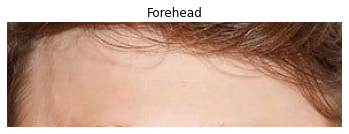

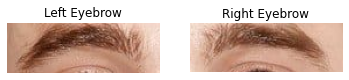

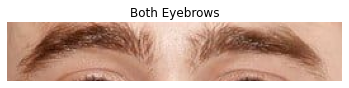

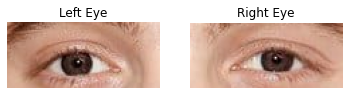

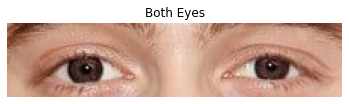

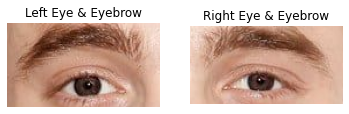

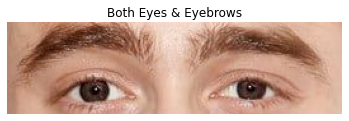

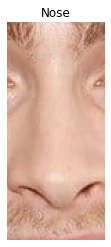

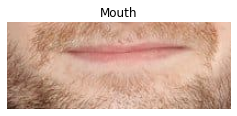

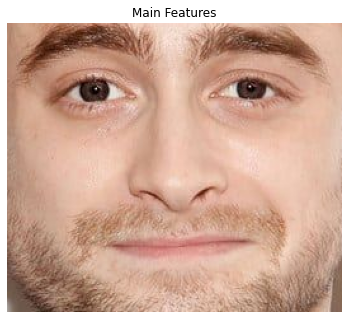

In [8]:
main()